## Aufgabe 1 : Schätzung und Test im bivariaten Modell ##

**Verwendeter Datensatz:** https://www.kaggle.com/datasets/mirichoi0218/insurance

**Ziel:** Vorhersage medizinischer Kosten auf Basis verschiedener unabhängiger Variablen

**Allgemeines Vorgehen:**
1. Daten laden und aufbereiten
2. EDA
3. Modellspezifikation
4. Modellschätzung
5. Test der Annahmen des Modells
6. Modellbewertung
7. Hypothesentest
8. Interpretation der Ergebnisse


In [2]:
# necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from scipy import stats
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt
from scipy.stats import levene
from sklearn.feature_selection import f_regression
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

1. Daten laden und aufbereiten (Daten bereinigen/transformieren und fehlende Werte beseitigen)

In [3]:
# load database
insurance_data = pd.read_csv('insurance.csv')
print(insurance_data.head())
print()
print("shape: ", insurance_data.shape)

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

shape:  (1338, 7)


In [4]:
# get general information
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
# missing data points
print('Missing data points:')
print(insurance_data.isnull().sum())

Missing data points:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [6]:
# one hot encoding

data = pd.get_dummies(insurance_data)
print(data.head())

   age     bmi  children      charges  sex_female  sex_male  smoker_no  \
0   19  27.900         0  16884.92400        True     False      False   
1   18  33.770         1   1725.55230       False      True       True   
2   28  33.000         3   4449.46200       False      True       True   
3   33  22.705         0  21984.47061       False      True       True   
4   32  28.880         0   3866.85520       False      True       True   

   smoker_yes  region_northeast  region_northwest  region_southeast  \
0        True             False             False             False   
1       False             False             False              True   
2       False             False             False              True   
3       False             False              True             False   
4       False             False              True             False   

   region_southwest  
0              True  
1             False  
2             False  
3             False  
4             Fals

In [7]:
data.columns

Index(['age', 'bmi', 'children', 'charges', 'sex_female', 'sex_male',
       'smoker_no', 'smoker_yes', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

2. EDA (Verteilung der Variablen verstehen und potenzielle Beziehungen zwischen den Variablen identifizieren)

In [8]:
# Summary statistics
print('Summary statistics:')
insurance_data.describe().round(2)
#data.describe().round(2)

Summary statistics:


,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43


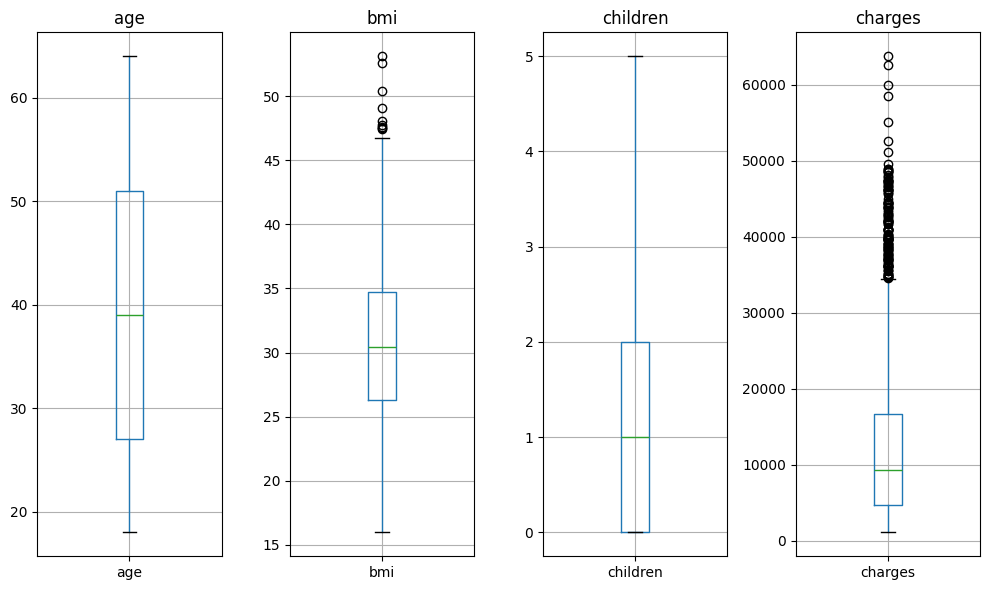

In [9]:
# Box und Whiskerplots

df = insurance_data[['age', 'bmi', 'children', 'charges']]

plt.figure(figsize=(10, 6))  

num_columns = len(df.columns) 

# Für jede Spalte im DataFrame einen Boxplot erstellen
for i, column in enumerate(df.columns):
    plt.subplot(1, num_columns, i+1)  #Für jede Spalte ein eigenen Plot
    df.boxplot(column)  
    plt.title(column)  

plt.tight_layout() 
plt.show()  

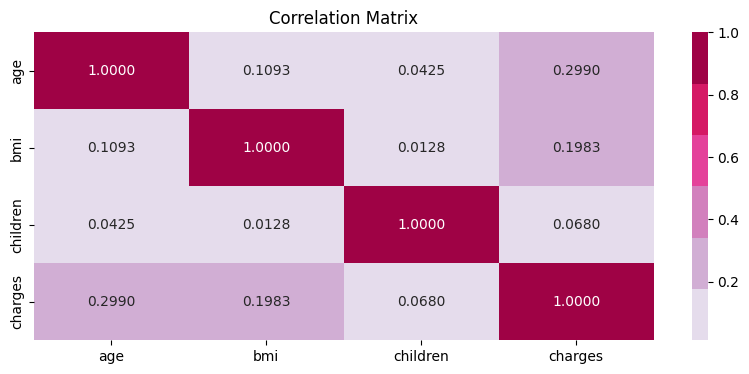

In [10]:
# Data Visualization

num_values = insurance_data.select_dtypes(include=[np.number]) # leave out cat values

# Correlation Matrix
correlation_matrix = num_values.corr()

colormap = sns.color_palette("PuRd") 

plt.figure(figsize=(10, 4))
sns.heatmap(correlation_matrix, cmap = colormap, annot=True, fmt=".4f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

Korrelationsplot zeigt, dass die abhängige Variable charges am meisten mit Age (0,299) und bmi(0,19) korreliert.
Die unabhängigen Variablen korrilieren untereinander schwächer (bis 0,10) sodass davon auszugehen ist dass wir keine interdependenzne haben

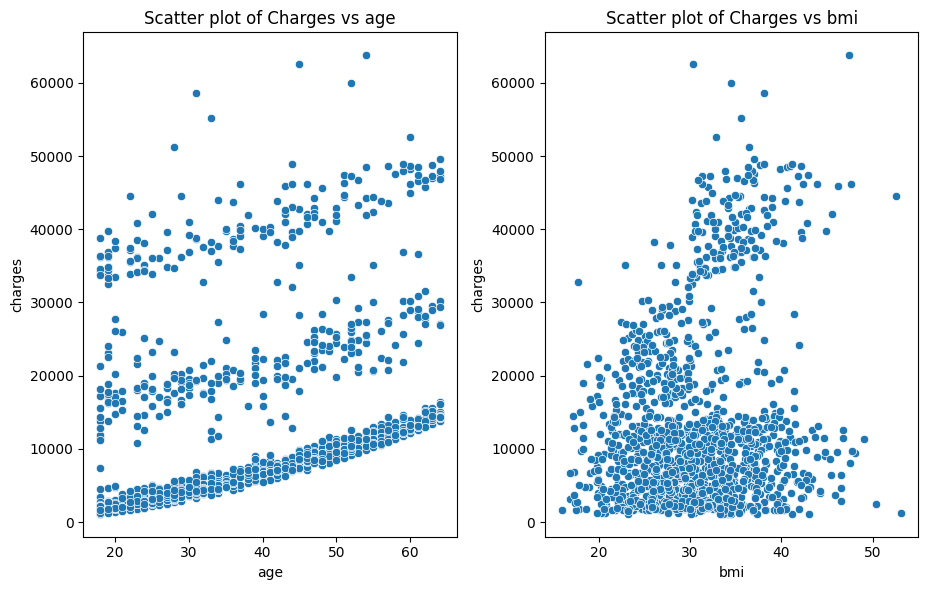

In [11]:
# Scatter plot of independent variables vs. dependent variable with highest correlation

f = plt.figure(figsize=(14,6))
ax = f.add_subplot(131)
sns.scatterplot(x='age',y='charges',data=insurance_data,ax=ax)
ax.set_title('Scatter plot of Charges vs age')

ax = f.add_subplot(132)
sns.scatterplot(x='bmi',y='charges',data=insurance_data)
ax.set_title('Scatter plot of Charges vs bmi')

#ax = f.add_subplot(133)
#sns.scatterplot(x='children',y='charges',data=insurance_data)
#ax.set_title('Scatter plot of Charges vs children')

plt.tight_layout()
plt.show()

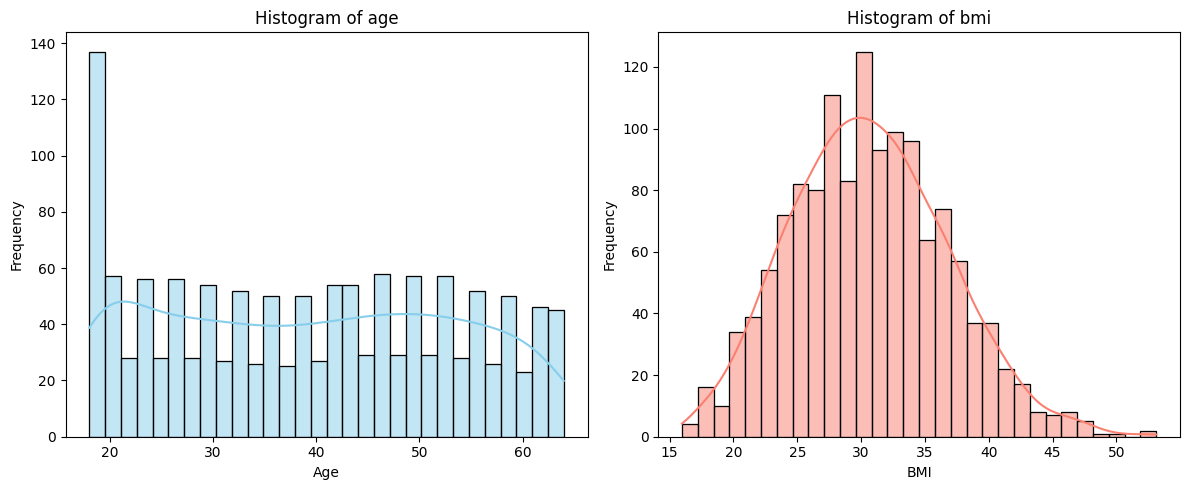

In [12]:
# Create a figure and subplots
plt.figure(figsize=(12, 5))

# Histogram of age
plt.subplot(1, 2, 1)
sns.histplot(insurance_data['age'], bins=30, kde=True, color='skyblue')
plt.title('Histogram of age')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Histogram of bmi
plt.subplot(1, 2, 2)
sns.histplot(insurance_data['bmi'], bins=30, kde=True, color='salmon')
plt.title('Histogram of bmi')
plt.xlabel('BMI')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

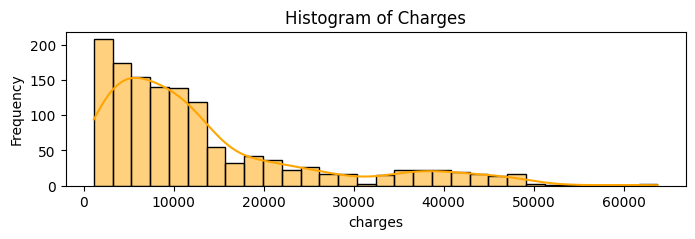

In [13]:
# Histogram of dependent variable charges
plt.figure(figsize=(8, 2))
sns.histplot(insurance_data['charges'], bins=30, kde=True, color = "orange")
plt.title('Histogram of Charges')
plt.xlabel('charges')
plt.ylabel('Frequency')
plt.show()


___

3. Modellspezifikation (bivariates Modell mit zugehörigen Variablen definieren)

In [14]:
# Split the dataset into train and test sets
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(insurance_data[['age']], insurance_data['charges'], test_size=0.2, random_state=42)
X_train_bmi, X_test_bmi, y_train_bmi, y_test_bmi = train_test_split(insurance_data[['bmi']], insurance_data['charges'], test_size=0.2, random_state=42)

In [15]:
# Specify the model (bivariate linear regression)

# Fit the linear regression model for age
lm_age = LinearRegression()
lm_age.fit(X_train_age, y_train_age)

# Fit the linear regression model for bmi
lm_bmi = LinearRegression()
lm_bmi.fit(X_train_bmi, y_train_bmi)

LinearRegression()

Der Koeffizient besagt, dass für jede zusätzliche Einheit der Charge um X Einheiten steigen wird.

Die Y-Intercept repräsentiert die abhängige Variable, wenn die unabhängige Variable null ist. 

Hier ist die Interpretation von der Intercept als Bedeutungslos anzusehen ?

___

4. Modellschätzung (Parameter des Modells schätzen)

In [16]:
# Predict charges for test sets
y_pred_age = lm_age.predict(X_test_age)
y_pred_bmi = lm_bmi.predict(X_test_bmi)

print(y_pred_age[:5])
print(y_pred_bmi[:5])

[14703.77387469 12538.40483659 19275.10851067 14944.37043448
  8448.26332018]
[11232.66307168 13134.01812818 11903.72956221 11456.35190186
 13879.64756211]


In [17]:
# metrics for evaluation
mse_age = mean_squared_error(y_test_age, y_pred_age).round(2)
r2_age = r2_score(y_test_age, y_pred_age).round(4)
print('Mean squared error for age:', mse_age)
print('R2 score for age:', r2_age)
print("Intercept:", lm_age.intercept_)
print("Coefficient:", lm_age.coef_[0])

print()

mse_bmi = mean_squared_error(y_test_bmi, y_pred_bmi).round(2)
r2_bmi = r2_score(y_test_bmi, y_pred_bmi).round(4)
print('Mean squared error for bmi:', mse_bmi)
print('R2 score for bmi:', r2_bmi)
print("Intercept:", lm_bmi.intercept_)
print("Coefficient:", lm_bmi.coef_[0])

Mean squared error for age: 135983957.48
R2 score for age: 0.1241
Intercept: 3876.928684191691
Coefficient: 240.59655978877493

Mean squared error for bmi: 149085057.04
R2 score for bmi: 0.0397
Intercept: 1353.0730722046683
Coefficient: 392.43654416987977


Interpretation der Metrics: Model Age im Vergleich zu Model BMI

- Model Age hat einen niedrigere MSE Wert im Vergleich zu Model BMI
- Model Age hat einen R2 Score von 0.1241 -> ca. 12% Varianz der Zielvariable 
- Model BMI hat einen  R2 Score von 0.0397  -> ca. 4% Varianz der Zielvariable 

Modellauswahl

Auswahl des Modelles Age, da diese Variable einen "größeren" Einfluss hat als das Modell BMI. 

In [18]:
## hier besseres Modell auswählen und damit weiterarbeiten

___

5. Test der Annahmen des Modells

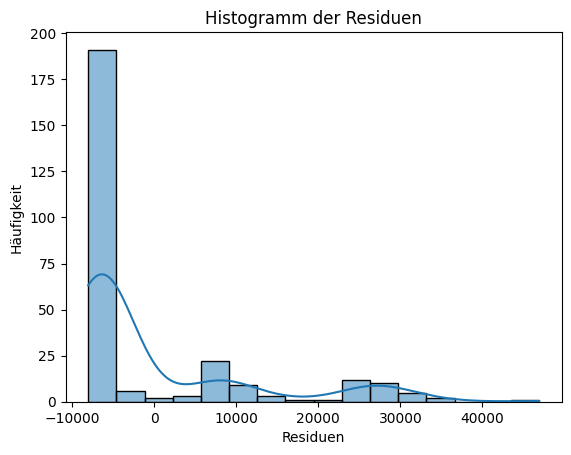

Shapiro-Wilk-Test Statistik: 0.6457548092828254
p-Wert: 3.067991782745721e-23
Mittelwert der Residuen: -197.61387555532588


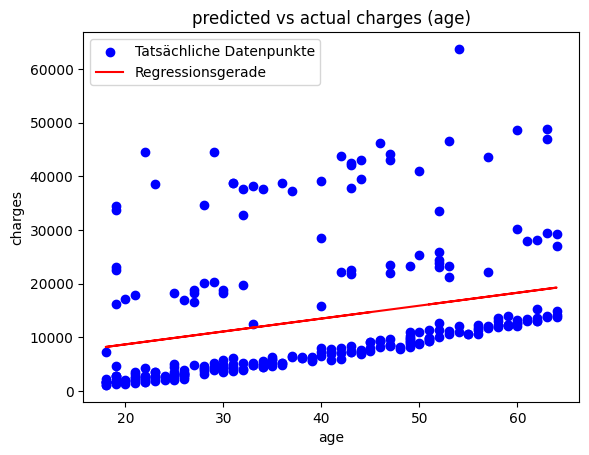

Levene-Test Statistik: 1.593053023330235, p-Wert: 0.20799599179380207
Breusch-Pagan-Test Statistik: 0.7581772445964221, p-Wert: 0.38389955189464076
Goldfeld-Quandt-Test Statistik: 1.2389607278785704, p-Wert: 0.10983516678358572


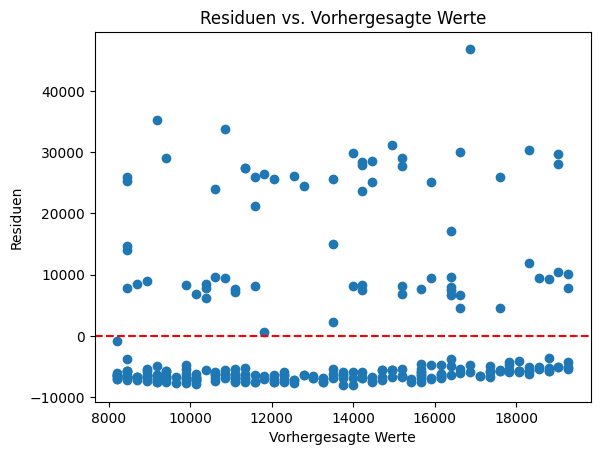

Durbin-Watson Statistik: 1.8554934075110674


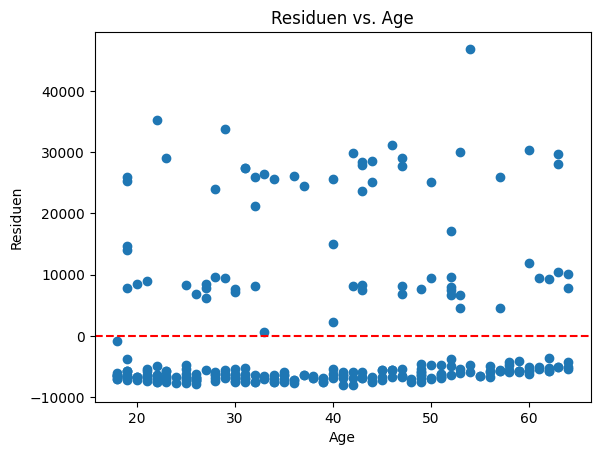

In [19]:
### TO DO

# Normalverteilung der Residuen

y_pred = lm_age.predict(X_test_age) 
residuals = y_test_age - y_pred

#grafische Veranschaulichung
sns.histplot(residuals, kde=True)
plt.title('Histogramm der Residuen')
plt.xlabel('Residuen')
plt.ylabel('Häufigkeit')
plt.show()
#Statistischer Test auf Normalverteilung (Shapiro-Wilk-Tests)
#H0: X normalverteilt
#H1: X nicht normalverteilt 
stat, p_value = shapiro(residuals)
print('Shapiro-Wilk-Test Statistik:', stat)
print('p-Wert:', p_value) #keine Normalverteilung, da p-Wert < 0,05


# Erwartungswert der Residuen --> vgl. mit Mittelwert
mean_residuals = np.mean(residuals)
print("Mittelwert der Residuen:", mean_residuals)


# Homoskedastizität der Residuen
#...zunehmendes Streuen um Regressionsgrade --> leichte Heteroskedastizität 
plt.scatter(X_test_age, y_test_age, color='blue', label='Tatsächliche Datenpunkte')
plt.plot(X_test_age, lm_age.predict(X_test_age), color='red', label='Regressionsgerade')
plt.xlabel('age')
plt.ylabel('charges')
plt.title('predicted vs actual charges (age)')
plt.legend()
plt.show()
# Levene-Test
#1 Teile die Daten anhand des Medians des Alters für den Levene-Test
median_age = X_test_age['age'].median()
group1 = residuals[X_test_age['age'] <= median_age]
group2 = residuals[X_test_age['age'] > median_age]
#2 # Durchführung des Levene-Tests
levene_stat, levene_p = levene(group1, group2)
print(f'Levene-Test Statistik: {levene_stat}, p-Wert: {levene_p}')
# Breusch-Pagan-Test
#1 Füge eine Konstante zum DataFrame hinzu
X_test_age_with_constant = sm.add_constant(X_test_age)
#2 Führe den Breusch-Pagan-Test durch
bp_test = het_breuschpagan(residuals, X_test_age_with_constant)
bp_stat, bp_p_value, _, _ = bp_test
#3 Ausgabe der Testergebnisse
print(f'Breusch-Pagan-Test Statistik: {bp_stat}, p-Wert: {bp_p_value}')
# Goldfeld-Quandt-Test
#1 Führe den Goldfeld-Quandt-Test durch
gq_test = het_goldfeldquandt(y_test_age, X_test_age_with_constant)
gq_stat, gq_p_value = gq_test[:2]
#2 Ausgabe der Testergebnisse
print(f'Goldfeld-Quandt-Test Statistik: {gq_stat}, p-Wert: {gq_p_value}')


# Unabhängigkeit der Residuen (Autokorrelation)
# ...Man sieht wieder das zunehmende Streuen --> Heteroskedastizität
# ...Man erkennt keine systematischen Autokorrelationen, sondern zufällige Verteilung um 0 Linie (z.B. kein zyklisches Schwingen oder andere Muster)
plt.scatter(y_pred, residuals)
plt.title('Residuen vs. Vorhergesagte Werte')
plt.xlabel('Vorhergesagte Werte')
plt.ylabel('Residuen')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()
#Durbin Watson Test (Autokorrelation)
#H0: ρ1=0 (keine Autokorrelation 1. Ordnung --> gegenwärtigen Werte der Residuen in einem Regressionsmodell werden nicht systematisch von den vorangegangenen Werten beeinflusst)
dw_stat = durbin_watson(residuals)
print("Durbin-Watson Statistik:", dw_stat) #Werte nahe 2 -> Keine Autokorrelation

# Stichprobenvariation von X

# Exogenität der Regressoren
# ....keine klaren Muster wie einen Trend oder zyklische Abweichungen, dass die Residuen systematisch mit dem Alter variieren
plt.scatter(X_test_age['age'], residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuen vs. Age')
plt.xlabel('Age')
plt.ylabel('Residuen')
plt.show()

6. Modellbewertung (Güte des Modells bewerten)

TODO here: nochmal zsmfassen , interpret values und annahmen

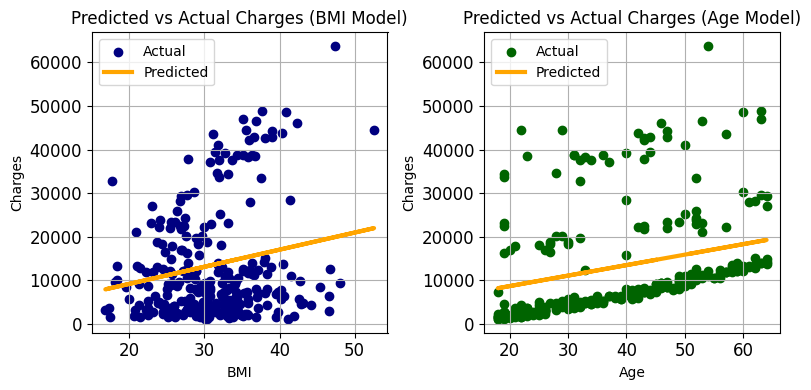

In [20]:
# Create subplots
plt.figure(figsize=(8, 4))

# Plot for BMI model
plt.subplot(1, 2, 1)
plt.scatter(X_test_bmi, y_test_bmi, color='navy', label='Actual')
plt.plot(X_test_bmi, y_pred_bmi, color='orange', linewidth=3, label='Predicted')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.title('Predicted vs Actual Charges (BMI Model)')
plt.legend()
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot for Age model
plt.subplot(1, 2, 2)
plt.scatter(X_test_age, y_test_age, color='darkgreen', label='Actual')
plt.plot(X_test_age, y_pred_age, color='orange', linewidth=3, label='Predicted')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.title('Predicted vs Actual Charges (Age Model)')
plt.legend()
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


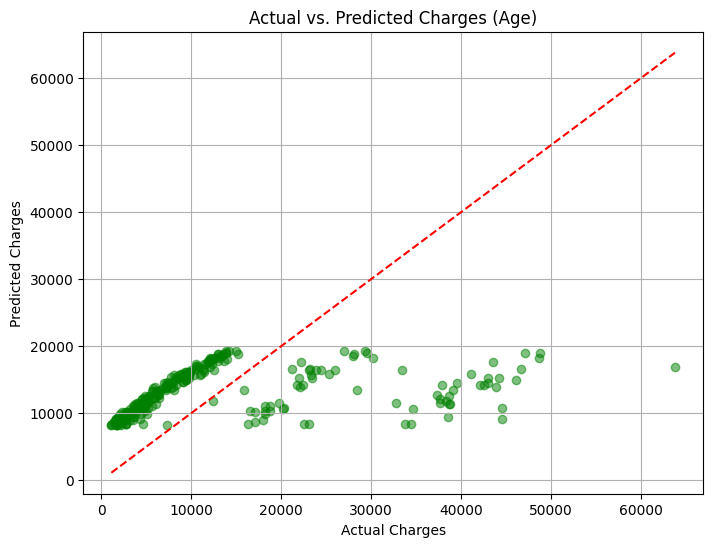

In [21]:
# Make predictions on the test set for age
predictions_age = lm_age.predict(X_test_age)

# Plot predicted vs actual values for age
plt.figure(figsize=(8, 6))
plt.scatter(y_test_age, predictions_age, alpha=0.5, color='green')
plt.plot([min(y_test_age), max(y_test_age)], [min(y_test_age), max(y_test_age)], color='red', linestyle='--')
plt.title('Actual vs. Predicted Charges (Age)')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.grid(True)
plt.show()


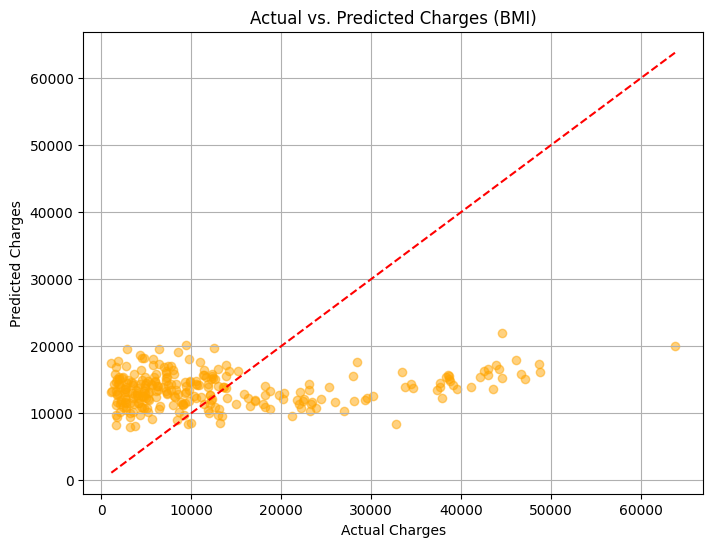

In [24]:
# Make predictions on the test set for bmi
predictions_bmi = lm_bmi.predict(X_test_bmi)

# Plot predicted vs actual values for bmi
plt.figure(figsize=(8, 6))
plt.scatter(y_test_bmi, predictions_bmi, alpha=0.5, color='orange')
plt.plot([min(y_test_bmi), max(y_test_bmi)], [min(y_test_bmi), max(y_test_bmi)], color='red', linestyle='--')
plt.title('Actual vs. Predicted Charges (BMI)')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.grid(True)
plt.show()


____

7. Hypothesentests (Prüfung, ob die Parameter deines Modells signifikant von Null verschieden sind; z.B. T-Test)

**Null and Alternative Hypotheses:**<br>
Null Hypothesis:<br>
The null hypothesis states that there is no significant relationship between the independent variable and the dependent variable (i.e., the regression coefficient is zero).<br>
<br>
Alternative Hypothesis:<br>
The alternative hypothesis states that there is a significant relationship between the independent variable and the dependent variable (i.e., the regression coefficient is not zero).

In [22]:
## T-Test

# HO: Coefficient = 0
# H1: Coefficient != 0

def perform_t_test():
    # T-Test for Variable Age
    residuals_age = y_test_age - y_pred_age
    degrees_of_freedom_age = len(X_test_age) - 2

    # Standard error of the coefficients
    mse = np.mean(residuals_age ** 2, axis=0)
    std_error_coef = np.sqrt(mse / np.sum((X_test_age - np.mean(X_test_age))**2))

    # Coefficients
    coef = lm_age.coef_[0]

    # T-values
    t_values = coef / std_error_coef

    # Critical t-value (two-tailed, 95% confidence level)
    alpha = 0.05
    critical_t_value = stats.t.ppf(1 - alpha/2, degrees_of_freedom_age)

    # Print results
    print("Coefficient:", coef)
    print("Standard Error of Coefficient:", std_error_coef)
    print("T-values:", t_values)
    print("Critical t-value:", critical_t_value)

    # Perform the test
    for i, t in enumerate(t_values):
        if np.abs(t) > critical_t_value:
            print("Coefficient", i, "is statistically significant.")
        else:
            print("Coefficient", i, "is not statistically significant.")

perform_t_test()

Coefficient: 240.59655978877493
Standard Error of Coefficient: age    51.107424
dtype: float64
T-values: age    4.707664
dtype: float64
Critical t-value: 1.9689223241409017
Coefficient 0 is statistically significant.


/Users/tina_brckh/anaconda3/envs/basic_fhw/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


The age variable has a statistically significant impact on the dependent variable, and the coefficient suggests that as age increases, the dependent variable also tends to increase, holding all other variables constant

In [23]:
# F-Test --> Besitzt das Modell über Stichprobe hinaus Gültigkeit für Grundgesamtheit
# Perform F-test
# martin

8. Interpretation der Ergebnisse (Schlussfolgerungen ableiten)